# 1. Set Up


In [ ]:
from huggingface_hub import notebook_login

notebook_login()


# 2. Load Data

In [3]:
## Upload data
# from datasets import load_dataset
# dataset = load_dataset("imagefolder", data_dir="D:\Pictures\wukong\lgd")
# dataset.push_to_hub("BoHu370/Land_grandfather")
# dataset = dataset['train']

Resolving data files:   0%|          | 0/29 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/14 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [4]:
from datasets import load_dataset

dataset_id = "BoHu370/Land_grandfather"  # CHANGE THIS TO YOUR {hub_username}/{dataset_id}
dataset = load_dataset(dataset_id, split="train")
dataset

Generating train split:   0%|          | 0/14 [00:00<?, ? examples/s]

Dataset({
    features: ['image'],
    num_rows: 14
})

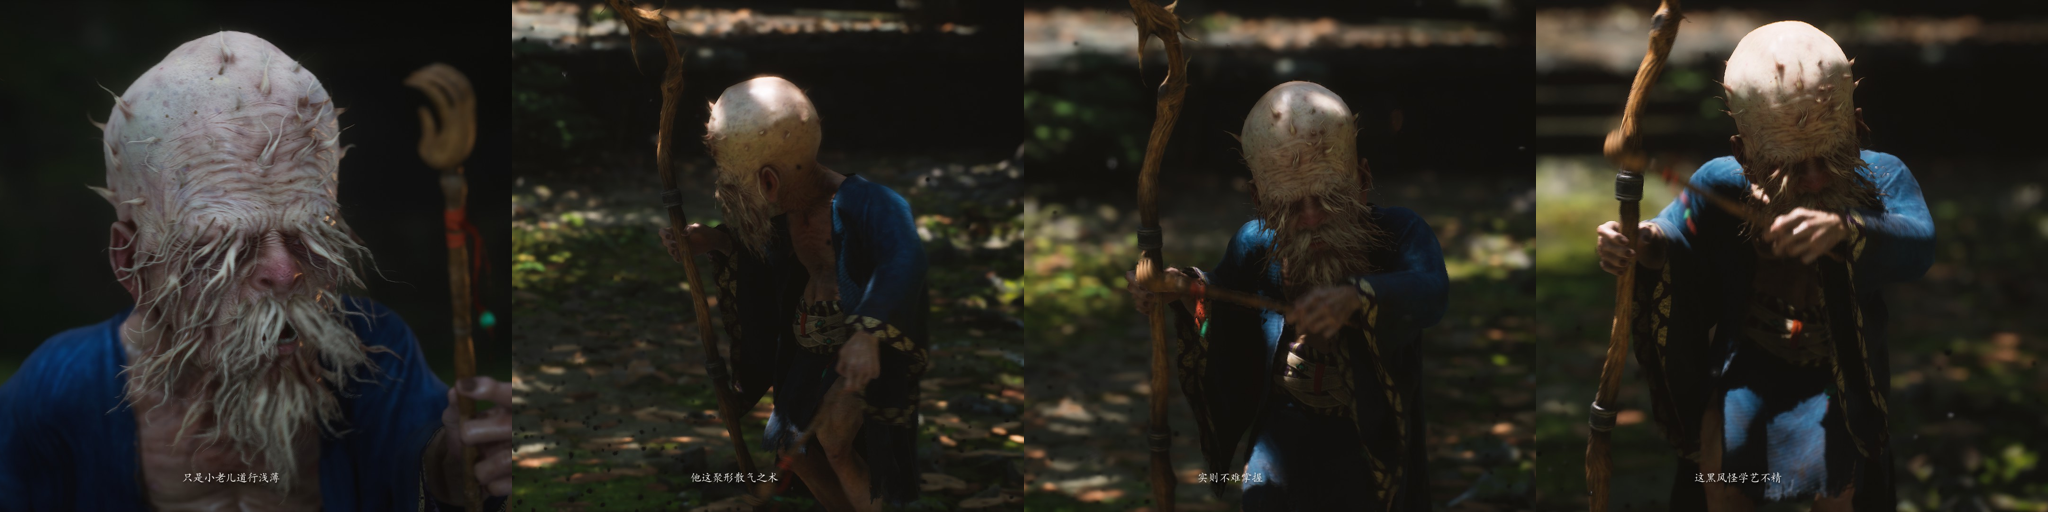

In [5]:
from PIL import Image


def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid


num_samples = 4
image_grid(dataset["image"][:num_samples], rows=1, cols=num_samples)

In [6]:
name_of_your_concept = "lgd"  
type_of_thing = "old man"  
instance_prompt = f"a photo of {name_of_your_concept} {type_of_thing}"
print(f"Instance prompt: {instance_prompt}")

# 3. Create Training Dataset

In [7]:
from torch.utils.data import Dataset
from torchvision import transforms


class DreamBoothDataset(Dataset):
    def __init__(self, dataset, instance_prompt, tokenizer, size=512):
        self.dataset = dataset
        self.instance_prompt = instance_prompt
        self.tokenizer = tokenizer
        self.size = size
        self.transforms = transforms.Compose(
            [
                transforms.Resize(size),
                transforms.CenterCrop(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        example = {}
        image = self.dataset[index]["image"]
        example["instance_images"] = self.transforms(image)
        example["instance_prompt_ids"] = self.tokenizer(
            self.instance_prompt,
            padding="do_not_pad",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids
        return example

In [8]:
from transformers import CLIPTokenizer

# The Stable Diffusion checkpoint we'll fine-tune
model_id = "CompVis/stable-diffusion-v1-4"
tokenizer = CLIPTokenizer.from_pretrained(
    model_id,
    subfolder="tokenizer",
)

train_dataset = DreamBoothDataset(dataset, instance_prompt, tokenizer)
train_dataset[0]

c:\Users\Administrator\.conda\envs\diffusion\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


{'instance_images': tensor([[[-0.8902, -0.8902, -0.8902,  ..., -0.9216, -0.9216, -0.9216],
          [-0.8902, -0.8902, -0.8902,  ..., -0.9216, -0.9216, -0.9216],
          [-0.8824, -0.8824, -0.8824,  ..., -0.9216, -0.9216, -0.9216],
          ...,
          [-0.9216, -0.9294, -0.9216,  ..., -0.6784, -0.6706, -0.6627],
          [-0.9216, -0.9294, -0.9294,  ..., -0.6863, -0.6784, -0.6706],
          [-0.9216, -0.9294, -0.9294,  ..., -0.6941, -0.6863, -0.6784]],
 
         [[-0.8745, -0.8745, -0.8745,  ..., -0.9216, -0.9216, -0.9216],
          [-0.8745, -0.8745, -0.8745,  ..., -0.9216, -0.9216, -0.9216],
          [-0.8667, -0.8667, -0.8667,  ..., -0.9216, -0.9216, -0.9216],
          ...,
          [-0.8980, -0.9059, -0.8980,  ..., -0.7333, -0.7333, -0.7412],
          [-0.8980, -0.9059, -0.9059,  ..., -0.7412, -0.7412, -0.7490],
          [-0.8980, -0.9059, -0.9059,  ..., -0.7490, -0.7490, -0.7569]],
 
         [[-0.8980, -0.8980, -0.8980,  ..., -0.9373, -0.9373, -0.9373],
         

In [9]:
import torch


def collate_fn(examples):
    input_ids = [example["instance_prompt_ids"] for example in examples]
    pixel_values = [example["instance_images"] for example in examples]
    pixel_values = torch.stack(pixel_values)
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    input_ids = tokenizer.pad(
        {"input_ids": input_ids}, padding=True, return_tensors="pt"
    ).input_ids

    batch = {
        "input_ids": input_ids,
        "pixel_values": pixel_values,
    }
    return batch

# 4. Load Components of Stable Diffusion Pipeline

In [10]:
from diffusers import AutoencoderKL, UNet2DConditionModel
from transformers import CLIPFeatureExtractor, CLIPTextModel

text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")
feature_extractor = CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32")

c:\Users\Administrator\.conda\envs\diffusion\lib\site-packages\transformers\models\clip\feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


# 5. Fine-tune the Model


In [11]:
learning_rate = 2e-06
max_train_steps = 2000

In [14]:
from argparse import Namespace

args = Namespace(
    pretrained_model_name_or_path=model_id,
    resolution=512, # Reduce this if you want to save some memory
    train_dataset=train_dataset,
    instance_prompt=instance_prompt,
    learning_rate=learning_rate,
    max_train_steps=max_train_steps,
    train_batch_size=1,
    gradient_accumulation_steps=1, # Increase this if you want to lower memory usage
    max_grad_norm=1.0,
    gradient_checkpointing=True,  # Set this to True to lower the memory usage
    use_8bit_adam=True,  # Use 8bit optimizer from bitsandbytes
    seed=3434554,
    sample_batch_size=2,
    output_dir="my-dreambooth-lgd",  # Where to save the pipeline
)

In [15]:
import math

import torch.nn.functional as F
from accelerate import Accelerator
from accelerate.utils import set_seed
from diffusers import DDPMScheduler, PNDMScheduler, StableDiffusionPipeline
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from torch.utils.data import DataLoader
from tqdm.auto import tqdm


def training_function(text_encoder, vae, unet):

    accelerator = Accelerator(
        gradient_accumulation_steps=args.gradient_accumulation_steps,
    )

    set_seed(args.seed)

    if args.gradient_checkpointing:
        unet.enable_gradient_checkpointing()

    # Use 8-bit Adam for lower memory usage or to fine-tune the model in 16GB GPUs
    if args.use_8bit_adam:
        import bitsandbytes as bnb
        optimizer_class = bnb.optim.AdamW8bit
    else:
        optimizer_class = torch.optim.AdamW

    optimizer = optimizer_class(
        unet.parameters(),  # Only optimize unet
        lr=args.learning_rate,
    )

    noise_scheduler = DDPMScheduler(
        beta_start=0.00085,
        beta_end=0.012,
        beta_schedule="scaled_linear",
        num_train_timesteps=1000,
    )

    train_dataloader = DataLoader(
        args.train_dataset,
        batch_size=args.train_batch_size,
        shuffle=True,
        collate_fn=collate_fn,
    )

    unet, optimizer, train_dataloader = accelerator.prepare(
        unet, optimizer, train_dataloader
    )

    # Move text_encode and vae to gpu
    text_encoder.to(accelerator.device)
    vae.to(accelerator.device)

    # We need to recalculate our total training steps as the size of the training dataloader may have changed
    num_update_steps_per_epoch = math.ceil(
        len(train_dataloader) / args.gradient_accumulation_steps
    )
    num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

    # Train!
    total_batch_size = (
        args.train_batch_size
        * accelerator.num_processes
        * args.gradient_accumulation_steps
    )
    # Only show the progress bar once on each machine
    progress_bar = tqdm(
        range(args.max_train_steps), disable=not accelerator.is_local_main_process
    )
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        unet.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet):
                # Convert images to latent space
                with torch.no_grad():
                    latents = vae.encode(batch["pixel_values"]).latent_dist.sample()
                    latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn(latents.shape).to(latents.device)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(
                    0,
                    noise_scheduler.config.num_train_timesteps,
                    (bsz,),
                    device=latents.device,
                ).long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                with torch.no_grad():
                    encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                noise_pred = unet(
                    noisy_latents, timesteps, encoder_hidden_states
                ).sample
                loss = (
                    F.mse_loss(noise_pred, noise, reduction="none")
                    .mean([1, 2, 3])
                    .mean()
                )

                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(unet.parameters(), args.max_grad_norm)
                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= args.max_train_steps:
                break

        accelerator.wait_for_everyone()

    # Create the pipeline using the trained modules and save it
    if accelerator.is_main_process:
        print(f"Loading pipeline and saving to {args.output_dir}...")
        scheduler = PNDMScheduler(
            beta_start=0.00085,
            beta_end=0.012,
            beta_schedule="scaled_linear",
            skip_prk_steps=True,
            steps_offset=1,
        )
        pipeline = StableDiffusionPipeline(
            text_encoder=text_encoder,
            vae=vae,
            unet=accelerator.unwrap_model(unet),
            tokenizer=tokenizer,
            scheduler=scheduler,
            safety_checker=StableDiffusionSafetyChecker.from_pretrained(
                "CompVis/stable-diffusion-safety-checker"
            ),
            feature_extractor=feature_extractor,
        )
        pipeline.save_pretrained(args.output_dir)

In [16]:
from accelerate import notebook_launcher

num_of_gpus = 1  # CHANGE THIS TO MATCH THE NUMBER OF GPUS YOU HAVE
notebook_launcher(
    training_function, args=(text_encoder, vae, unet), num_processes=num_of_gpus
)

with torch.no_grad():
    torch.cuda.empty_cache()

  0%|          | 0/2000 [00:00<?, ?it/s]

c:\Users\Administrator\.conda\envs\diffusion\lib\site-packages\diffusers\models\attention_processor.py:2358: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  hidden_states = F.scaled_dot_product_attention(


In [17]:
args.output_dir

'my-dreambooth-lgd'

In [18]:
pipe = StableDiffusionPipeline.from_pretrained(
    args.output_dir,
    torch_dtype=torch.float16,
).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

# 6. Inference

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

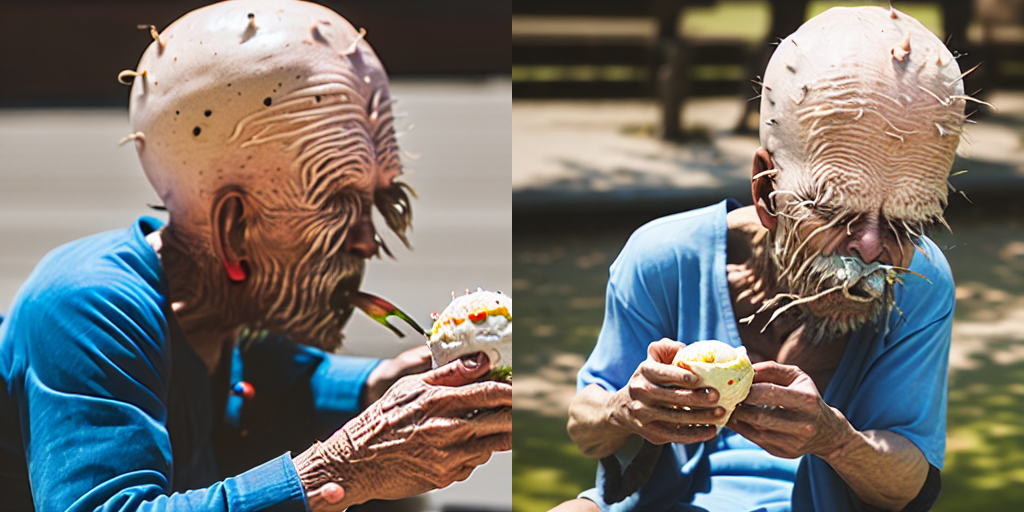

In [23]:
prompt = f"a photo of {name_of_your_concept} {type_of_thing} eating icecream"


guidance_scale = 5

num_cols = 2
all_images = []
for _ in range(num_cols):
    images = pipe(prompt, guidance_scale=guidance_scale).images
    all_images.extend(images)

image_grid(all_images, 1, num_cols)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

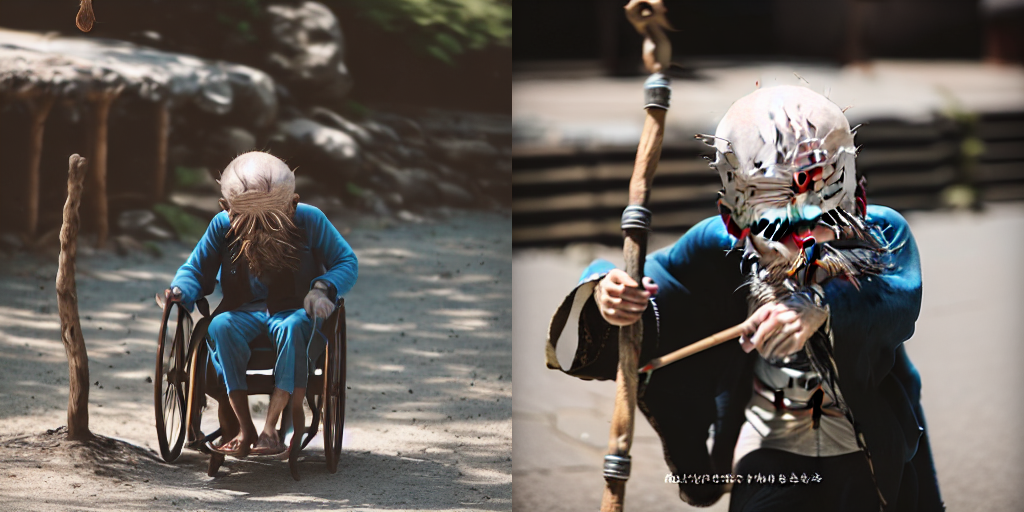

In [24]:
prompt = f"a photo of {name_of_your_concept} {type_of_thing} driving car"

guidance_scale = 5

num_cols = 2
all_images = []
for _ in range(num_cols):
    images = pipe(prompt, guidance_scale=guidance_scale).images
    all_images.extend(images)

image_grid(all_images, 1, num_cols)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

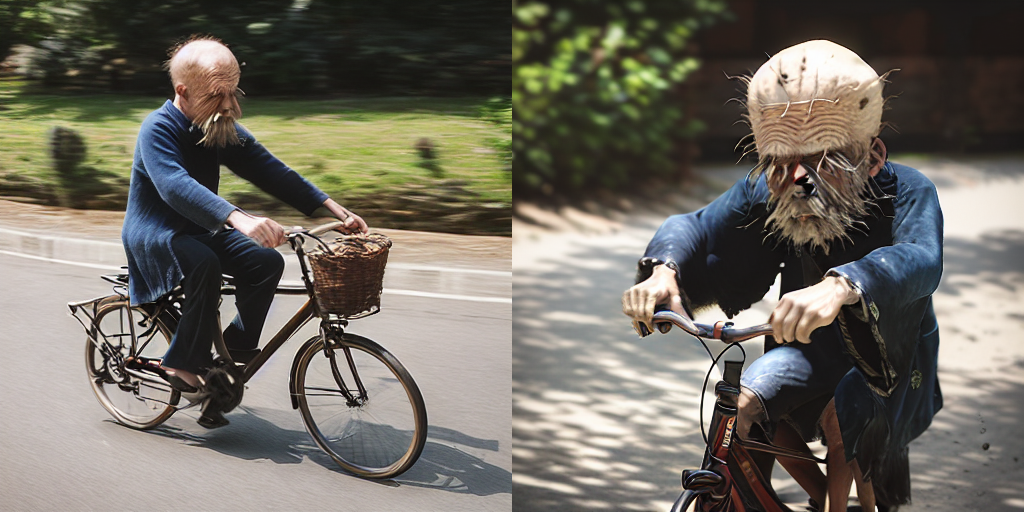

In [25]:
prompt = f"a photo of {name_of_your_concept} {type_of_thing} driving a bicycle"

guidance_scale = 5

num_cols = 2
all_images = []
for _ in range(num_cols):
    images = pipe(prompt, guidance_scale=guidance_scale).images
    all_images.extend(images)

image_grid(all_images, 1, num_cols)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

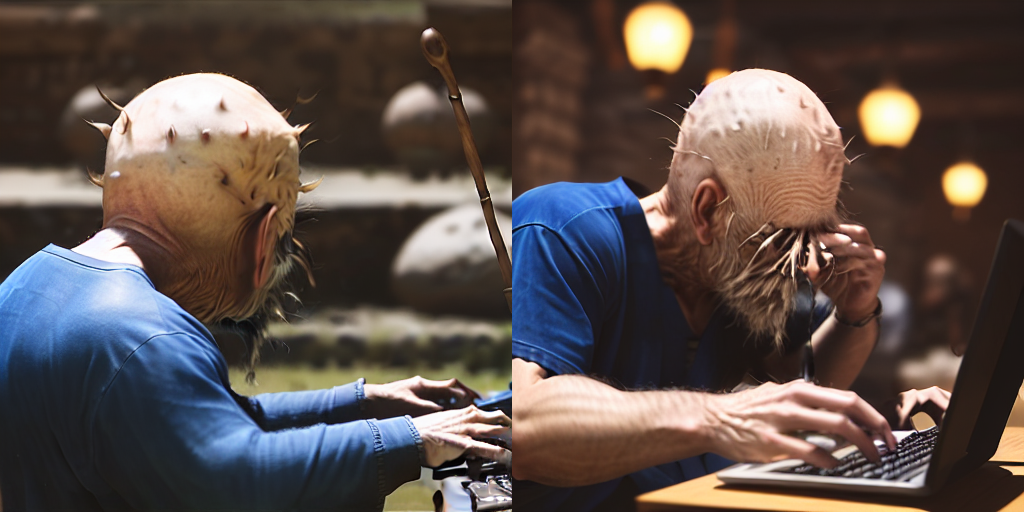

In [27]:
prompt = f"a photo of {name_of_your_concept} {type_of_thing} playing computer game"

guidance_scale = 5

num_cols = 2
all_images = []
for _ in range(num_cols):
    images = pipe(prompt, guidance_scale=guidance_scale).images
    all_images.extend(images)

image_grid(all_images, 1, num_cols)

# 7. Push Model to hub

In [30]:
model_name = "lgd-old-man"

In [31]:
description = f"""
This is a Stable Diffusion model fine-tuned on `{type_of_thing}` images.

The images is from the game Black Myth WUKONG.
"""

In [32]:
from huggingface_hub import HfApi, ModelCard, create_repo, get_full_repo_name

# Set up repo and upload files
hub_model_id = get_full_repo_name(model_name)
create_repo(hub_model_id)
api = HfApi()
api.upload_folder(folder_path=args.output_dir, path_in_repo="", repo_id=hub_model_id)

content = f"""
---
license: creativeml-openrail-m
tags:
- pytorch
- diffusers
- stable-diffusion
- text-to-image
- diffusion-models-class
- dreambooth-hackathon
- BLACK-MTYH-WUKONG
widget:
- text: {prompt}
---

# DreamBooth model for the {name_of_your_concept} concept trained by {api.whoami()["name"]} on the {dataset_id} dataset.

This is a Stable Diffusion model fine-tuned on the {name_of_your_concept} concept with DreamBooth. It can be used by modifying the `instance_prompt`: **{instance_prompt}**

This model was created as part of the DreamBooth Hackathon 🔥. Visit the [organisation page](https://huggingface.co/dreambooth-hackathon) for instructions on how to take part!

## Description

{description}

## Usage

```python
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained('BoHu370/lgd-old-man')

prompt = f"a photo of {name_of_your_concept} {type_of_thing} playing computer game"
guidance_scale = 5
num_cols = 2
all_images = []
for _ in range(num_cols):
    images = pipe(prompt, guidance_scale=guidance_scale).images
    all_images.extend(images)

image_grid(all_images, 1, num_cols)

```
"""

card = ModelCard(content)
hub_url = card.push_to_hub(hub_model_id)
print(f"Upload successful! Model can be found here: {hub_url}")
print(
    f"View your submission on the public leaderboard here: https://huggingface.co/spaces/dreambooth-hackathon/leaderboard"
)

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]